In [2]:
import socket
import struct

# initialize variables
robotIP = "192.168.137.217"
PRIMARY_PORT = 30001
SECONDARY_PORT = 30002
REALTIME_PORT = 30003

# URScript command being sent to the robot
urscript_command = "movel(p[-0.55, -0.25, -0.15, 0, 0, 0], a=0.12, v=0.05)"
urscript_command = "get_actual_tcp_pose()"


# Creates new line
new_line = "\n"

def send_urscript_command(command: str):
    """
    This function takes the URScript command defined above, 
    connects to the robot server, and sends 
    the command to the specified port to be executed by the robot.

    Args:
        command (str): URScript command
        
    Returns: 
        None
    """
    try:
        # Create a socket connection with the robot IP and port number defined above
        s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        s.connect((robotIP, PRIMARY_PORT))

        # Appends new line to the URScript command (the command will not execute without this)
        command = command+new_line
        
        # Send the command
        s.sendall(command.encode('utf-8'))
        
        r= s.recv(1024)

        # Close the connection
        s.close()





    except Exception as e:
        print(f"An error occurred: {e}")

send_urscript_command(urscript_command)

In [3]:
import socket
import struct

def get_ur_pose():
    ip = "192.168.137.217"
    port = 30003  # 实时数据端口
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.connect((ip, port))
    data = s.recv(1108)  # 获取一个完整的状态包

    # 解析 TCP 位姿，从第444字节开始，连续6个 double（48 字节）
    pose = struct.unpack('!6d', data[444:444+48])
    s.close()
    return pose


pose = get_ur_pose()
print("TCP Pose:", pose)


TCP Pose: (-0.8772390731363366, -0.2385877538837436, 0.17333267092214802, 0.002933522718139697, -0.006836935231922203, -0.00023345817009107125)


Camera opened successfully.
Actual camera resolution: 2048x1536
Cropping region: X[924:1124], Y[668:868]


KeyboardInterrupt: 

In [33]:
import numpy as np
import cv2
import glob

# 1. 准备棋盘格参数
CHECKERBOARD = (6,9) # 棋盘格内角点数量 (行, 列)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# 世界坐标系中的3D点
objp = np.zeros((CHECKERBOARD[0]*CHECKERBOARD[1],3), np.float32)
objp[:,:2] = np.mgrid[0:CHECKERBOARD[0],0:CHECKERBOARD[1]].T.reshape(-1,2)
# 如果你知道棋盘格方格的实际尺寸（例如 20mm），可以乘以这个值
objp = objp * 24 # 例如，每个方格 20mm

# 存储所有图像的3D点和2D点
objpoints = [] # 真实世界中的3D点
imgpoints = [] # 图像中的2D点

# 获取所有棋盘格图像的路径 (假设你把图片放在 'calibration_images/' 目录下)
images = glob.glob('calibration_images/*.jpg') # 或 .jpg

for fname in images:
    img = cv2.imread(fname)
    cv2.namedWindow('img', cv2.WINDOW_NORMAL) # 创建一个窗口来显示图像
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 查找棋盘格角点
    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)

    # 如果找到角点，则添加对象点和图像点
    if ret == True:
        objpoints.append(objp)
        # 精细化角点位置
        corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)

        # 绘制角点并显示 (可选)
        cv2.drawChessboardCorners(img, CHECKERBOARD, corners2, ret)
        cv2.imshow('img', img)
        # if cv2.waitKey(0) == ord('q'):
        #     continue # 按 'q' 键跳过当前图像
    else:
        print(f"Warning: Could not find chessboard corners in {fname}")

cv2.destroyAllWindows()

# 2. 相机标定
print("Starting camera calibration...")
ret, K, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(K, dist_coeffs, (desired_width, desired_height), 1, (desired_width, desired_height))

np.savez('calibration_data.npz', ret=ret, K=K, dist_coeffs=dist_coeffs, rvecs=rvecs, tvecs=tvecs,new_camera_matrix=new_camera_matrix)
if ret:
    print("\nCalibration successful!")
    print("Camera Matrix (K):\n", K)
    print("\nDistortion Coefficients (dist_coeffs):\n", dist_coeffs)
  
    # 或者从摄像头获取一帧进行测试 (假设你已经连接了摄像头)
    cap = cv2.VideoCapture(0)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, desired_width) # 设置分辨率
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, desired_height) # 设置分辨率
    if not cap.isOpened():
        print("Error: Could not open camera for demonstration.")
        exit()
    ret_cam, img = cap.read()
    cap.release()
    if not ret_cam:
        print("Error: Could not read frame from camera for demonstration.")
        exit()


    # 方法二：使用 initUndistortRectifyMap 和 remap (更适合实时视频流)
    # mapx, mapy = cv2.initUndistortRectifyMap(K, dist_coeffs, None, new_camera_matrix, (w,h), 5) # 5 for CV_32FC1
    # remap_undistorted_img = cv2.remap(img, mapx, mapy, cv2.INTER_LINEAR)

    # cv2.imshow('Original Image', img)
    # cv2.imshow('Remapped Undistorted Image', remap_undistorted_img)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
 
else:
    print("Calibration failed!")

Starting camera calibration...


KeyboardInterrupt: 

In [6]:
import cv2
import numpy as np

desired_width = 2592 
desired_height = 1944
cap = cv2.VideoCapture(0)
cv2.namedWindow('Undistorted Frame', cv2.WINDOW_NORMAL)  # 创建一个窗口来显示矫正后的图像

if not cap.isOpened():
    print("Error: Could not open camera for demonstration.")
    exit()

clicked_x, clicked_y = -1, -1

object_points = [] # 用于存储世界坐标系中的点
img_points = []  # 用于存储图像坐标系中的点

calibration_data = np.load('calibration_data.npz')
K = calibration_data['K']
dist_coeffs = calibration_data['dist_coeffs']

new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(K, dist_coeffs, (desired_width, desired_height), 0, (desired_width, desired_height))

def mouse_callback(event, x, y, flags, param):
    """
    鼠标事件发生时被调用的函数。
    """
    global clicked_x, clicked_y # 声明使用全局变量
    global object_points, img_points

    if event == cv2.EVENT_LBUTTONDOWN: # 检测鼠标左键按下事件
        clicked_x, clicked_y = x, y
        print(f"Clicked coordinates: ({clicked_x}, {clicked_y})")

        if len(object_points) < 8:
            pose = get_ur_pose()[:2]
            object_points.append(pose)
            img_points.append([clicked_x, clicked_y])
            


            print(f"Object points: {object_points}")
            print(f"Image points: {img_points}")


        

        # 计算单应性矩阵
        if len(object_points) >= 8:
            
            H, status = cv2.findHomography(np.array(object_points, dtype=np.float32), np.array(img_points, dtype=np.float32))
            print(f"Homography matrix: {H}")
            np.save('Homography_matrix.npy',H)
            print("Saved Homography matrix.")
            
        return

cap.set(cv2.CAP_PROP_FRAME_WIDTH, desired_width)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, desired_height)
while True:
    ret, frame = cap.read()
    if not ret:
        print("Error: Could not read frame from camera for demonstration.")
        break

    
    undistorted_frame = cv2.undistort(frame, K, dist_coeffs, None, new_camera_matrix)
    undistorted_frame = undistorted_frame[:1250, 135:1300]
    
 


    # cv2.imshow('Original Frame', frame)
    # cv2.imshow('Undistorted Frame', cv2.resize(undistorted_frame, (desired_width, desired_height)))  # 缩放显示窗口大小
    cv2.imshow('Undistorted Frame', undistorted_frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    cv2.setMouseCallback("Undistorted Frame", mouse_callback)
  
  
cap.release()
cv2.destroyAllWindows()

Clicked coordinates: (505, 685)
Object points: [(-1.1033704990649336, -0.34914161245955955)]
Image points: [[505, 685]]
Clicked coordinates: (900, 821)
Object points: [(-1.1033704990649336, -0.34914161245955955), (-0.9841827939034165, -0.34903936142033043)]
Image points: [[505, 685], [900, 821]]
Clicked coordinates: (834, 439)
Object points: [(-1.1033704990649336, -0.34914161245955955), (-0.9841827939034165, -0.34903936142033043), (-1.034570497741996, -0.25103030968584855)]
Image points: [[505, 685], [900, 821], [834, 439]]
Clicked coordinates: (918, 171)
Object points: [(-1.1033704990649336, -0.34914161245955955), (-0.9841827939034165, -0.34903936142033043), (-1.034570497741996, -0.25103030968584855), (-1.0345779330348783, -0.1690735716337092)]
Image points: [[505, 685], [900, 821], [834, 439], [918, 171]]
Clicked coordinates: (343, 311)
Object points: [(-1.1033704990649336, -0.34914161245955955), (-0.9841827939034165, -0.34903936142033043), (-1.034570497741996, -0.25103030968584855),

error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window_w32.cpp:2546: error: (-27:Null pointer) NULL window: 'Undistorted Frame' in function 'cvSetMouseCallback'


In [ ]:
import numpy as np
import cv2
import time




desired_width = 2592 
desired_height = 1944





H = np.load('Homography_matrix.npy')
print(H)
calibration_data = np.load('calibration_data.npz')
K = calibration_data['K']
dist_coeffs = calibration_data['dist_coeffs']

new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(K, dist_coeffs, (desired_width, desired_height), 0, (desired_width, desired_height))

cap = cv2.VideoCapture(0)
cv2.namedWindow('Undistorted Frame', cv2.WINDOW_NORMAL)  # 创建一个窗口来显示矫正后的图像
# cv2.namedWindow('Original Frame', cv2.WINDOW_NORMAL)  # 创建一个窗口来显示原始图像
if not cap.isOpened():
    print("Error: Could not open camera for demonstration.")
    exit()

clicked_x, clicked_y = -1, -1

object_points = [] # 用于存储世界坐标系中的点
img_points = []  # 用于存储图像坐标系中的点



def mouse_callback(event, x, y, flags, param):
    """
    鼠标事件发生时被调用的函数。
    """

    global clicked_x, clicked_y # 声明使用全局变量
    global object_points,tcp_points, img_points
    if event == cv2.EVENT_LBUTTONDOWN: # 检测鼠标左键按下事件

        clicked_x, clicked_y = x, y
        print(f"Clicked at ({clicked_x}, {clicked_y})")
        x_curr, y_curr,z = get_ur_pose()[:3]

        point_pixel = np.array([[clicked_x], [clicked_y], [1]], dtype=np.float32)
        point_world_homo = np.linalg.inv(H) @ point_pixel
        x_obj = point_world_homo[0] / point_world_homo[2]
        y_obj = point_world_homo[1] / point_world_homo[2]

        r = 0.015
        x_tcp = x_obj + r*(x_obj - x_curr)/np.sqrt((x_obj - x_curr)**2 + (y_obj - y_curr)**2)
        y_tcp = y_obj + r*(y_obj - y_curr)/np.sqrt((x_obj - x_curr)**2 + (y_obj - y_curr)**2)

        urscript_command = f'movel(p[{x_tcp[0]},{y_tcp[0]},{z},0.0,0.0,0.0],a = 0.12,v = 0.3)'
        # urscript_command = f'movel(p[{x_obj[0]},{y_obj[0]},{z},0.0,0.0,0.0],a = 0.12,v = 0.05)'

        # tcp_points.append([x_tcp, y_tcp, z])
        print(urscript_command)
        send_urscript_command(urscript_command)

        print(f"Object points: {object_points}")
        print(f"Image points: {img_points}")

        return clicked_x, clicked_y

cap.set(cv2.CAP_PROP_FRAME_WIDTH, desired_width)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, desired_height)

while True:
    ret, frame = cap.read()
    if not ret:
        print("Error: Could not read frame from camera for demonstration.")
        break
    # 使用 cv2.undistort 对每一帧进行畸变矫正
    undistorted_frame = cv2.undistort(frame, K, dist_coeffs, None, new_camera_matrix)
    undistorted_frame = undistorted_frame[:1250, 135:1300]


    cv2.circle(undistorted_frame, (clicked_x, clicked_y), 15, (255, 0, 255), -1)  # 在中心点画一个绿色圆圈
    # cv2.imshow('Undistorted Frame', cv2.resize(undistorted_frame, (desired_width, desired_height)))
    cv2.imshow('Undistorted Frame',undistorted_frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    


    cv2.setMouseCallback("Undistorted Frame", mouse_callback)

cap.release()
cv2.destroyAllWindows()


[[ 3.19749972e+03  1.05838379e+03  4.38403597e+03]
 [ 1.10302954e+03 -3.17822560e+03  7.70454812e+02]
 [ 1.38408357e-02  5.48469860e-02  1.00000000e+00]]
Clicked at (473, 614)
movel(p[-1.1273110516209,-0.32045168952878517,0.1799890613820807,0.0,0.0,0.0],a = 0.12,v = 0.3)
Object points: []
Image points: []
Clicked at (478, 666)
movel(p[-1.104578506331152,-0.35884487056829945,0.1799417338001298,0.0,0.0,0.0],a = 0.12,v = 0.3)
Object points: []
Image points: []
Clicked at (456, 465)
movel(p[-1.14235091654171,-0.27992117699619035,0.17994937922380394,0.0,0.0,0.0],a = 0.12,v = 0.3)
Object points: []
Image points: []
Clicked at (522, 858)
movel(p[-1.0765918661160354,-0.40702193576374995,0.1800207070124081,0.0,0.0,0.0],a = 0.12,v = 0.3)
Object points: []
Image points: []
Clicked at (492, 739)
movel(p[-1.1097089025825146,-0.35149410613917736,0.18004558031119033,0.0,0.0,0.0],a = 0.12,v = 0.3)
Object points: []
Image points: []
Clicked at (493, 839)
movel(p[-1.087228847874187,-0.40508622368259073,

error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window_w32.cpp:2546: error: (-27:Null pointer) NULL window: 'Undistorted Frame' in function 'cvSetMouseCallback'


: 

In [5]:
import gymnasium as gym
from gymnasium.spaces import Box, Discrete,Tuple
import numpy as np
import pygame

# Define colors
WHITE = (255, 255, 255)
RED = (255, 0, 0)
GREEN = (0, 255, 0)
BLUE = (0, 0, 255)  # Color for the trajectory

class CustomEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 60}

    def __init__(self,render_mode=None):
        super().__init__()
        self.grid_size = 10
        self.pause = False
        self.domain_randomization = False
        self.render_mode = render_mode

        # Define two separate thresholds for obstacle handling
        self.distance_threshold_penalty = 3  # Penalty zone threshold (larger value)
        self.distance_threshold_collision = 1.5  # Collision threshold (smaller value)
        self.penalty_factor = 5  # Penalty scaling factor
        self.distance_reward_factor = 10
        self.smooth_action_penalty = 1
        self.steps = 0
        self.margin = 0.1
        self.stride_hand = 0.8
        self.pre_distance = 0  # Previous distance to goal, used for reward shaping
        self.current_distance = 0  # Current distance to goal, used for reward shaping
        self.max_steps = 50  # Set a maximum number of steps to prevent infinite loops
        # Action space (dx, dy)
        self.action_space = Box(low=-1, high=1, shape=(2,), dtype=np.float32)
        # Observation space (robot_x, robot_y, goal_x, goal_y)
        self.observation_shape = 2+2+2+1+1  # Robot position, hand position, velocity_hand,radius_hand, and distance to hand
        self.observation_space = Box(low=0, high=np.array([self.grid_size,self.grid_size, self.grid_size, self.grid_size,1,1 , (2**0.5)*self.grid_size,0.5*self.grid_size]), 
                                    shape=(self.observation_shape,), dtype=np.float32)

        self.random = True
        # For rendering
        self.window = None
        self.clock = None
        self.cell_size = 50 # Pixels per grid unit
        self.trajectory_points = [] # New: List to store past robot positions

    def _get_obs(self):
        
        return np.concatenate(([self.robot_position]+ [self.hand_position]+[self.last_action]+
                               [np.array([self.current_distance])]+
                               [np.array([min(self.robot_position[0],
                                              self.robot_position[1],
                                              self.grid_size-self.robot_position[0],
                                              self.grid_size-self.robot_position[1]) ])]))

    def _get_info(self):
        return {
            "distance_to_hand": self.current_distance,
            "robot_position": self.robot_position,
            "hand_position": self.hand_position,
        }

    def reset(self, seed=None, options=None):

        super().reset()
        self.stride_hand = 0.8* np.random.uniform(0.8, 1.2)  # Randomize stride length
        self.distance_threshold_collision *= np.random.uniform(0.8, 1.2)  # Randomize collision threshold
        self.distance_threshold_penalty *= np.random.uniform(0.8, 1.2)  # Randomize penalty threshold
        self.noise_obs_sigma = np.random.uniform(0, 0.1)  # Add some noise to observation to make it more realistic
        self.noise_action_sigma = np.random.uniform(0,0.1)  # Add some noise to action to make it more realistic
        self.robot_position = np.random.uniform(self.margin, self.grid_size-self.margin, size=2)

        self.hand_position = np.random.uniform(self.margin, self.grid_size-self.margin, size=2)
        # self.hand_position = np.clip(self.hand_position, self.margin, self.grid_size-self.margin)  # Ensure hand stays within grid bounds
        
        self.current_distance = np.linalg.norm(self.robot_position - self.hand_position)
        self.current_distance = self.current_distance
        self.last_action = np.zeros(2)
        self.steps = 0
        self.trajectory_points = [self.robot_position.copy()] # New: Reset trajectory and add initial position
        
        return self._get_obs(), self._get_info()

    def _reward(self,action):
        terminated = False
        truncated = False
        reward = 0  # Initialize reward
        done_reason = None  # Initialize done reason

        # action regulation penalty

        reward -= 0.5 * np.sum(np.square(action))  # Penalty for large actions

        if np.any(self.robot_position <= self.margin) or np.any(self.grid_size-self.robot_position <=self.margin):
            reward -= 400
            terminated = True  # Truncate if robot goes out of bounds
            done_reason = "out of bounds"

        # self.robot_position = np.clip(self.robot_position, self.margin, self.grid_size-self.margin)  # Ensure robot stays within grid bounds
        # boundary penalty

        reward -= self.smooth_action_penalty*np.linalg.norm(action-self.last_action)  # Penalty for smooth action
        self.last_action = action
        # Auxiliary Rewards -  distance to hand
        self.current_distance = np.linalg.norm(self.robot_position - self.hand_position)
        reward += (self.current_distance-self.pre_distance)*self.distance_reward_factor  # Reward shaping based on distance change
        self.pre_distance = self.current_distance

        # Obstacle handling with two thresholds
        if self.current_distance < self.distance_threshold_collision:
            reward -= 100
            terminated = True  # Terminate if too close to obstacles
            done_reason = "collision with obstacle"
        elif self.current_distance < self.distance_threshold_penalty:
            reward -= self.penalty_factor * (self.distance_threshold_penalty - self.current_distance)  # Penalty for being too close to obstacles

        
        
        reward+=  4  # Small reward for each step taken to encourage exploration
        if self.steps >= self.max_steps:
            reward += 50
            truncated = True  # Truncate if max steps reached
        return reward,terminated,truncated,done_reason
        

    def step(self, action):
        if self.random:
            action+=np.random.normal(0,self.noise_action_sigma,size=self.action_space.shape)  # Add some noise to action to make it more realistic

        rand = np.random.rand()
        if rand < 0.1:
            move_hand = np.random.uniform(-1, 1, size=2)  # Randomly move the hand position slightly
        # elif rand < 0.2:
            # move_hand = np.random.uniform(-3, 3, size=2)  # Randomly move the hand position
        else:
        
            # move towards the robot position
            dir_vector = self.robot_position - self.hand_position
            if np.linalg.norm(dir_vector) > 0:
                dir_vector /= np.linalg.norm(dir_vector)
            move_hand = dir_vector * self.stride_hand  # Move hand towards robot position
        self.hand_position += move_hand  # Update hand position
        self.hand_position = np.clip(self.hand_position, self.margin, self.grid_size-self.margin)  # Ensure hand stays within grid bounds
        stride = 1  # Base stride length
        self.robot_position += action * stride  # Scale the action to control speed
        self.trajectory_points.append(self.robot_position.copy()) # New: Add current position to trajectory
        reward,terminated,truncated,done_reason = self._reward(action)
        info = self._get_info()
        info['done_reason'] = done_reason
        observation = self._get_obs()
        self.steps += 1
        if self.random:
            observation += np.random.normal(0, self.noise_obs_sigma, size=self.observation_shape)  # Add some noise to observation to make it more realistic

        return observation, reward, terminated, truncated, info

    def render(self, mode="human"):
 
        pygame.display.init()
        self.window = pygame.display.set_mode(
                (int(self.grid_size * self.cell_size), int(self.grid_size * self.cell_size))
            )
        pygame.display.set_caption("CustomEnv")
        if self.clock is None:
            self.clock = pygame.time.Clock()
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                import sys
                sys.exit() # Exit the program

            elif event.type == pygame.MOUSEBUTTONDOWN:
                mouse_x, mouse_y = event.pos
                self.hand_position = np.array([mouse_x/self.cell_size, mouse_y/self.cell_size])

            elif event.type == pygame.KEYDOWN:
                if event.key == pygame.K_SPACE:  # 空格键切换暂停
                    self.pause = not self.pause


        canvas = pygame.Surface((self.grid_size * self.cell_size, self.grid_size * self.cell_size))
        canvas.fill(WHITE)
        virus_image = pygame.image.load("hand.png").convert_alpha()  # Load an image if needed, but not used here
        robot_image = pygame.transform.scale(virus_image, (int(self.cell_size * 2), int(self.cell_size * 2)))  # Scale the image
        # New: Draw the trajectory
        if len(self.trajectory_points) > 1:
            scaled_points = []
            for point in self.trajectory_points:
                scaled_points.append((int(point[0] * self.cell_size), int(point[1] * self.cell_size)))
            
            # Draw lines between consecutive points
            pygame.draw.lines(canvas, BLUE, False, scaled_points, 2) # Blue line, not closed, 2 pixels wide
            
            # Optionally, draw small circles at each point to emphasize
            for point_coord in scaled_points:
                pygame.draw.circle(canvas, BLUE, point_coord, 3) # Small blue circles

        # Draw robot
        pygame.draw.circle(
            canvas,
            RED,
            (int(self.robot_position[0] * self.cell_size), int(self.robot_position[1] * self.cell_size)),
            int(self.cell_size * 0.2)
        )
        # Draw obstacles

        canvas.blit(robot_image, (int((self.hand_position[0]-1) * self.cell_size), int((self.hand_position[1]-1) * self.cell_size+1)))
        pygame.draw.circle(canvas,
                            GREEN, 
                            (int((self.hand_position[0]) * self.cell_size), 
                            int((self.hand_position[1]) * self.cell_size+1)), 
        int(self.cell_size * 0.2)
        )

        self.window.blit(canvas, canvas.get_rect())
        pygame.event.pump()
        pygame.display.flip()
        self.clock.tick(self.metadata["render_fps"])
        time.sleep(0.5)

    def close(self):
        pygame.display.quit()
        pygame.quit()





In [15]:
def render_environment(robot_position, hand_position, trajectory_points, grid_size=10, cell_size=50):
    WHITE = (255, 255, 255)
    RED = (255, 0, 0)
    GREEN = (0, 255, 0)
    BLUE = (0, 0, 255)

    window = pygame.display.set_mode((grid_size * cell_size, grid_size * cell_size))
    canvas = pygame.Surface((grid_size * cell_size, grid_size * cell_size))
    canvas.fill(WHITE)
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            pygame.quit()
            import sys
            sys.exit() # Exit the program

        elif event.type == pygame.MOUSEBUTTONDOWN:
            mouse_x, mouse_y = event.pos
            hand_position = np.array([mouse_x/cell_size, mouse_y/cell_size])

    if len(trajectory_points) > 1:
        scaled_points = [(int(point[0] * cell_size), int(point[1] * cell_size)) for point in trajectory_points]
        pygame.draw.lines(canvas, BLUE, False, scaled_points, 2)
        for point_coord in scaled_points:
            pygame.draw.circle(canvas, BLUE, point_coord, 3)
    virus_image = pygame.image.load("hand.png").convert_alpha()  # Load an image if needed, but not used here
    robot_image = pygame.transform.scale(virus_image, (int(cell_size * 2), int(cell_size * 2)))  # Scale the image
    pygame.draw.circle(canvas, RED, (int(robot_position[0] * cell_size), int(robot_position[1] * cell_size)), int(cell_size * 0.2))
    pygame.draw.circle(canvas, GREEN, (int(hand_position[0] * cell_size), int(hand_position[1] * cell_size)), int(cell_size * 0.2))
    canvas.blit(robot_image, (int((hand_position[0]-1) * cell_size), int((hand_position[1]-1) * cell_size)))

    window.blit(canvas, canvas.get_rect())
    pygame.display.flip()

    return hand_position

In [53]:
from stable_baselines3 import PPO,SAC
import numpy as np
import cv2
import time
import mediapipe as mp
from custom_env import CustomEnv
import pygame




env = CustomEnv()
env.random = False
model = SAC.load(
    "logs/best_model_sac7/best_model.zip",
    env=env,
    # custom_objects={
    #     "observation_space": env.observation_space,
    #     "action_space": env.action_space
    # }
)




mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils

hands = mp_hands.Hands(
    max_num_hands=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)



desired_width = 2592 
desired_height = 1944

H = np.load('Homography_matrix.npy')
print(H)
calibration_data = np.load('calibration_data.npz')
K = calibration_data['K']
dist_coeffs = calibration_data['dist_coeffs']

new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(K, dist_coeffs, (desired_width, desired_height), 0, (desired_width, desired_height))





cap = cv2.VideoCapture(0)
cv2.namedWindow('Undistorted Frame', cv2.WINDOW_NORMAL)  # 创建一个窗口来显示矫正后的图像
# cv2.namedWindow('Original Frame', cv2.WINDOW_NORMAL)  # 创建一个窗口来显示原始图像
if not cap.isOpened():
    print("Error: Could not open camera for demonstration.")
    exit()

clicked_x, clicked_y = 1000, 1000
position_hand_env = [0,0]
object_points = [] # 用于存储世界坐标系中的点
img_points = []  # 用于存储图像坐标系中的点



def mouse_callback(event, x, y, flags, param):
    """
    鼠标事件发生时被调用的函数。
    """

    global clicked_x, clicked_y # 声明使用全局变量
    # global position_hand_env
    if event == cv2.EVENT_LBUTTONDOWN: # 检测鼠标左键按下事件
        clicked_x, clicked_y = x, y
        # print(np.linalg.inv(H) @ np.array([x, y, 1],dtype=np.float32))
        # position_hand_env = np.linalg.inv(H) @ np.array([x, y, 1],dtype=np.float32)[:2]
        # print(np.linalg.inv(H) @ np.array([x, y, 1],dtype=np.float32))

        # position_hand_env = 

        return clicked_x, clicked_y

cap.set(cv2.CAP_PROP_FRAME_WIDTH, desired_width)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, desired_height)

frame_count = 0
fps = 0.0
fps_interval = 1.0
fps_ts = time.time()

last_trigger_time = time.time()
interval = 0.5
trajectory = []
last_action = [0,0]

while True:
    ret, frame = cap.read()
    if not ret:
        print("Error: Could not read frame from camera for demonstration.")
        break
    # 使用 cv2.undistort 对每一帧进行畸变矫正
    undistorted_frame = cv2.undistort(frame, K, dist_coeffs, None, new_camera_matrix)
    undistorted_frame = undistorted_frame[:1250, 135:1300]
    h , w = undistorted_frame.shape[:2]


    # cv2.circle(undistorted_frame, (clicked_x, clicked_y), 15, (255, 0, 255), -1)  # 在中心点画一个绿色圆圈
    # cv2.imshow('Undistorted Frame', cv2.resize(undistorted_frame, (desired_width, desired_height)))
    """
    rgb = cv2.cvtColor(undistorted_frame, cv2.COLOR_BGR2RGB)
    
    results = hands.process(rgb)

    if results.multi_hand_landmarks:
        for lm in results.multi_hand_landmarks:
            # 绘制关键点
            # mp_draw.draw_landmarks(undistorted_frame, lm, mp_hands.HAND_CONNECTIONS)

            # 获取像素坐标列表
            pts = [(int(pt.x * w), int(pt.y * h)) for pt in lm.landmark]
            # 多数情况下，手掌中心使用 landmarks 0, center
            # 这里使用所有21个点平均作为中心
            cx = int(np.mean([p[0] for p in pts]))
            cy = int(np.mean([p[1] for p in pts]))

            # 可视化中心点
            cv2.circle(undistorted_frame, (cx, cy), 8, (0, 0, 255), -1)

            position_hand_env = cx*10/w, cy*10/h
            # print(f"Hand center: ({cx}, {cy})")

        """













    position_hand_env = clicked_x*10/w, clicked_y*10/h
    
    key = cv2.waitKey(1) 
    if key== ord('q'):
        break
    
    now = time.time()
    if now - last_trigger_time > interval:
        
        position_robot_world = get_ur_pose()[:2]
        # print(position_robot_world)
        position_robot_pixel = H @ np.array([position_robot_world[0], position_robot_world[1], 1],dtype=np.float32)
        position_robot_pixel /= position_robot_pixel[2]

        # print(position_robot_pixel)

        position_robot_env = position_robot_pixel[0]*10 /w , position_robot_pixel[1]*10 / h


        distance_to_object = np.linalg.norm(np.array(position_robot_env) - np.array(position_hand_env))


        robot = np.array([position_robot_env],dtype=np.float32)

        hand = np.array([position_hand_env],dtype=np.float32)

        distance = np.array([distance_to_object],dtype=np.float32)
        boundary = np.array([min(position_robot_env[0],position_robot_env[1],10-position_robot_env[0],10-position_robot_env[1])],dtype=np.float32)
        last_action = np.array([last_action],dtype=np.float32)
        obs = np.concatenate((robot.flatten(),hand.flatten(),last_action.flatten(),distance.flatten(),boundary.flatten()))
        
        action, _states = model.predict(obs, deterministic=True)
        last_action = action    
        print(f"obs:{obs}\n action:{action}")
        action_pixel = action * np.array([desired_width/10,desired_height/10])
        
        # print(action_pixel)

        position_robot_pixel += np.array([action_pixel[0],action_pixel[1],1])
        # print(position_robot_pixel)
        position_robot_world = np.linalg.inv(H) @ np.array([position_robot_pixel[0], position_robot_pixel[1], 1],dtype=np.float32)
        position_robot_world /= position_robot_world[2]
        # print(position_robot_world)
        # print(action_pixel,position_robot_pixel,position_robot_world)

        urscript_command = f'movel(p[{position_robot_world[0]},{position_robot_world[1]},{0.179},0.0,0.0,0.0],a = 0.5,v = 0.2,r = 0.005)'

        send_urscript_command(urscript_command)

        last_trigger_time = now
        trajectory.append(position_robot_env)
        render_environment(obs[:2],obs[2:4],trajectory)

    cv2.setMouseCallback("Undistorted Frame", mouse_callback)
    frame_count += 1
    if (time.time() - fps_ts) > fps_interval:
        fps = frame_count / (time.time() - fps_ts)
        frame_count = 0
        fps_ts = time.time()

    cv2.putText(undistorted_frame, f"FPS: {fps:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    cv2.imshow('Undistorted Frame', undistorted_frame)
cap.release()
cv2.destroyAllWindows()



Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
[[ 3.19749972e+03  1.05838379e+03  4.38403597e+03]
 [ 1.10302954e+03 -3.17822560e+03  7.70454812e+02]
 [ 1.38408357e-02  5.48469860e-02  1.00000000e+00]]
obs:[3.456029  7.7076106 8.583691  8.        0.        0.        5.1359916
 2.2923894]
 action:[-0.00959939  0.06934369]
obs:[ 3.4560308   7.7069807   8.583691    8.         -0.00959939  0.06934369
  5.1360254   2.2930193 ]
 action:[-0.00544316  0.0825336 ]
obs:[ 3.4557931e+00  7.7060719e+00  8.5836906e+00  8.0000000e+00
 -5.4431558e-03  8.2533598e-02  5.1363149e+00  2.2939284e+00]
 action:[-0.00142175  0.08372688]
obs:[ 3.4559443e+00  7.7072430e+00  8.5836906e+00  8.0000000e+00
 -1.4217496e-03  8.3726883e-02  5.1360970e+00  2.2927568e+00]
 action:[0.00061667 0.08234775]
obs:[3.4559314e+00 7.7066226e+00 8.1373386e+00 7.6079998e+00 6.1666965e-04
 8.2347751e-02 4.6824465e+00 2.2933774e+00]
 action:[-0.03082526  0.03184843]
obs:[ 3.4559388   7.70693     8.137339

error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window_w32.cpp:2546: error: (-27:Null pointer) NULL window: 'Undistorted Frame' in function 'cvSetMouseCallback'


In [5]:
from stable_baselines3 import PPO
import numpy as np
import cv2
import time
import mediapipe as mp



cap = cv2.VideoCapture(0)
cv2.namedWindow('Undistorted Frame', cv2.WINDOW_NORMAL)  # 创建一个窗口来显示矫正后的图像
# cv2.namedWindow('Original Frame', cv2.WINDOW_NORMAL)  # 创建一个窗口来显示原始图像
if not cap.isOpened():
    print("Error: Could not open camera for demonstration.")
    exit()

clicked_x, clicked_y = 1000, 1000
position_hand_env = [0,0]
object_points = [] # 用于存储世界坐标系中的点
img_points = []  # 用于存储图像坐标系中的点



def mouse_callback(event, x, y, flags, param):
    """
    鼠标事件发生时被调用的函数。
    """

    global clicked_x, clicked_y # 声明使用全局变量
    # global position_hand_env
    if event == cv2.EVENT_LBUTTONDOWN: # 检测鼠标左键按下事件
        clicked_x, clicked_y = x, y
        # print(np.linalg.inv(H) @ np.array([x, y, 1],dtype=np.float32))
        # position_hand_env = np.linalg.inv(H) @ np.array([x, y, 1],dtype=np.float32)[:2]
        # print(np.linalg.inv(H) @ np.array([x, y, 1],dtype=np.float32))

        # position_hand_env = 

        return clicked_x, clicked_y

# cap.set(cv2.CAP_PROP_FPS, 60)
cap.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc(*'MJPG'))
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
# cap.set(cv2.CAP_PROP_FPS, 30)

frame_count = 0
fps = 0.0
fps_interval = 1.0
fps_ts = time.time()
last_trigger_time = time.time()
interval = 1
while True:
    ret, frame = cap.read()
    if not ret:
        print("Error: Could not read frame from camera for demonstration.")
        break
    # 使用 cv2.undistort 对每一帧进行畸变矫正
    # undistorted_frame = cv2.undistort(frame, K, dist_coeffs, None, new_camera_matrix)
    # h , w = undistorted_frame.shape[:2]


    # cv2.circle(undistorted_frame, (clicked_x, clicked_y), 15, (255, 0, 255), -1)  # 在中心点画一个绿色圆圈
    # cv2.imshow('Undistorted Frame', cv2.resize(undistorted_frame, (desired_width, desired_height)))

    # rgb = cv2.cvtColor(undistorted_frame, cv2.COLOR_BGR2RGB)
    # results = hands.process(rgb)

    # if results.multi_hand_landmarks:
    #     for lm in results.multi_hand_landmarks:
    #         # 绘制关键点
    #         # mp_draw.draw_landmarks(undistorted_frame, lm, mp_hands.HAND_CONNECTIONS)

    #         # 获取像素坐标列表
    #         pts = [(int(pt.x * w), int(pt.y * h)) for pt in lm.landmark]
    #         # 多数情况下，手掌中心使用 landmarks 0, center
    #         # 这里使用所有21个点平均作为中心
    #         cx = int(np.mean([p[0] for p in pts]))
    #         cy = int(np.mean([p[1] for p in pts]))

    #         # 可视化中心点
    #         cv2.circle(undistorted_frame, (cx, cy), 8, (0, 0, 255), -1)

    #         position_hand_env = cx*10/w, cy*10/h
    #         # print(f"Hand center: ({cx}, {cy})")







    # position_hand_env = clicked_x*10/w, clicked_y*10/h
    # key = cv2.waitKey(50) 
    # if key== ord('q'):
    #     break
    frame_count += 1
    now = time.time()
    if (now - fps_ts) > fps_interval:
        fps = frame_count / (now - fps_ts)
        frame_count = 0
        fps_ts = now
        print(f"FPS: {fps:.2f}")
    cv2.putText(frame, f"FPS: {fps:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    cv2.imshow('Undistorted Frame', frame)
cap.release()
cv2.destroyAllWindows()



FPS: 18.01
FPS: 29.82
FPS: 30.75
FPS: 29.75
FPS: 29.78
FPS: 29.76
FPS: 30.75
FPS: 29.75
FPS: 29.76
FPS: 29.78
FPS: 30.74
FPS: 29.78


KeyboardInterrupt: 

开始进行波峰波谷识别...
信号已使用高斯滤波进行平滑，sigma=15
识别到 20 个波峰。
识别到 0 个波谷。


C:\Users\PC\AppData\Local\Temp\ipykernel_24472\3872250821.py:87: UserWarning: Glyph 20449 (\N{CJK UNIFIED IDEOGRAPH-4FE1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\PC\AppData\Local\Temp\ipykernel_24472\3872250821.py:87: UserWarning: Glyph 21495 (\N{CJK UNIFIED IDEOGRAPH-53F7}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\PC\AppData\Local\Temp\ipykernel_24472\3872250821.py:87: UserWarning: Glyph 32034 (\N{CJK UNIFIED IDEOGRAPH-7D22}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\PC\AppData\Local\Temp\ipykernel_24472\3872250821.py:87: UserWarning: Glyph 24341 (\N{CJK UNIFIED IDEOGRAPH-5F15}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\PC\AppData\Local\Temp\ipykernel_24472\3872250821.py:87: UserWarning: Glyph 24133 (\N{CJK UNIFIED IDEOGRAPH-5E45}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\PC\AppData\Local\Temp\ipykernel_24472\3872250821.py:87: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEO

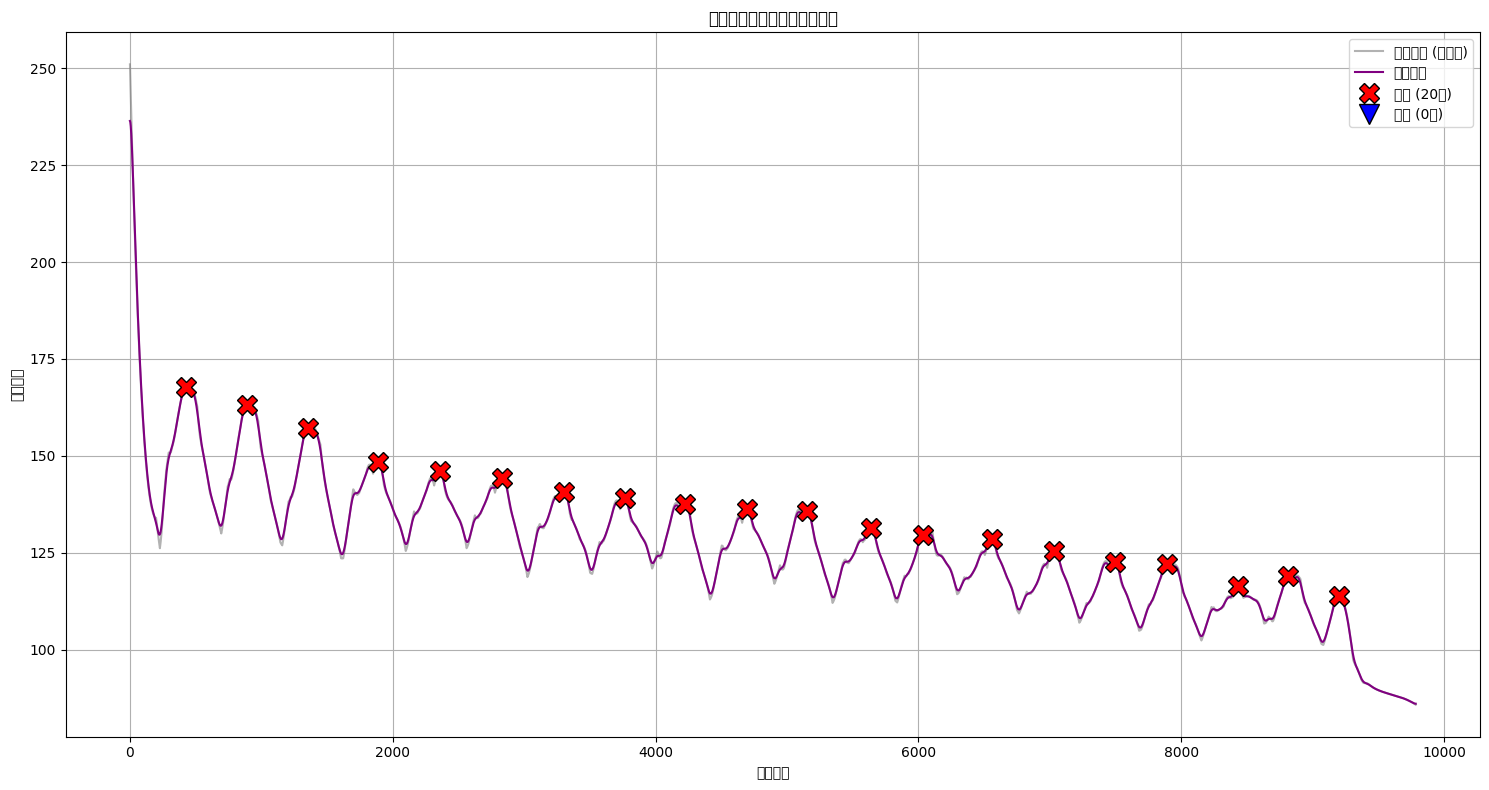


波峰波谷识别完成！


In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d # 用于平滑信号

def find_and_plot_peaks_troughs_no_time(signal,
                                         smoothing_sigma=3,
                                         peak_height=None, peak_distance=None,
                                         peak_prominence=None, peak_width=None,
                                         trough_height=None, trough_distance=None,
                                         trough_prominence=None, trough_width=None):
    """
    在一维信号中查找波峰和波谷，并在图中标注出来（不使用时间轴，X轴为索引）。

    参数:
    signal (array_like): 输入的一维信号数组。
    smoothing_sigma (float): 高斯平滑的标准差。值越大，平滑效果越强。
                             设置为 0 或 None 则不进行平滑。
    peak_height (float or tuple, optional): 识别波峰的最小高度 (或范围)。
    peak_distance (int, optional): 两个相邻波峰之间的最小水平距离 (采样点数)。
    peak_prominence (float, optional): 波峰的最小显著性。
    peak_width (float or tuple, optional): 波峰的最小宽度 (或范围)。
    trough_height (float or tuple, optional): 识别波谷的最小高度 (取负号后)。
    trough_distance (int, optional): 两个相邻波谷之间的最小水平距离 (采样点数)。
    trough_prominence (float, optional): 波谷的最小显著性 (取负号后)。
    trough_width (float or tuple, optional): 波谷的最小宽度 (取负号后)。
    """

    # X轴将是信号的索引
    x_axis_indices = np.arange(len(signal))

    # --- 1. 平滑信号 ---
    if smoothing_sigma is not None and smoothing_sigma > 0:
        smoothed_signal = gaussian_filter1d(signal, sigma=smoothing_sigma)
        print(f"信号已使用高斯滤波进行平滑，sigma={smoothing_sigma}")
    else:
        smoothed_signal = signal
        print("未对信号进行平滑处理。")

    # --- 2. 识别波峰 (Peaks) ---
    peak_params = {
        'height': peak_height,
        'distance': peak_distance,
        'prominence': peak_prominence,
        'width': peak_width
    }
    peak_params = {k: v for k, v in peak_params.items() if v is not None}
    
    peaks, _ = find_peaks(smoothed_signal, **peak_params)
    print(f"识别到 {len(peaks)} 个波峰。")

    # --- 3. 识别波谷 (Troughs) ---
    trough_params = {
        'height': trough_height,
        'distance': trough_distance,
        'prominence': trough_prominence,
        'width': trough_width
    }
    trough_params = {k: v for k, v in trough_params.items() if v is not None}
    
    troughs, _ = find_peaks(-smoothed_signal, **trough_params)
    print(f"识别到 {len(troughs)} 个波谷。")

    # --- 4. 绘图可视化 ---
    plt.figure(figsize=(15, 8))
    
    # 绘制原始信号
    plt.plot(x_axis_indices, signal, label='原始信号 (带噪声)', alpha=0.6, color='gray')
    
    # 绘制平滑后的信号
    if smoothing_sigma is not None and smoothing_sigma > 0:
        plt.plot(x_axis_indices, smoothed_signal, label='平滑信号', color='purple', linewidth=1.5)
    
    # 绘制波峰
    plt.plot(x_axis_indices[peaks], smoothed_signal[peaks], "X", markersize=15, 
             color='red', markeredgecolor='black', label=f'波峰 ({len(peaks)}个)')

    # 绘制波谷
    plt.plot(x_axis_indices[troughs], smoothed_signal[troughs], "v", markersize=15, 
             color='blue', markeredgecolor='black', label=f'波谷 ({len(troughs)}个)')

    plt.title('一维信号中的波峰与波谷识别')
    plt.xlabel('信号索引')
    plt.ylabel('信号幅值')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- 示例使用 ---
if __name__ == "__main__":
    # 假设你的信号数据是一个 Numpy 数组或列表
    # 你可以将你的实际信号数据替换这里的 `my_signal_data`
    
    np.random.seed(2025) # 为了结果可复现

    # 模拟一个包含噪声、周期性、尖峰和平台的一维信号
    # 这个信号有 2000 个数据点
    my_signal_data = data_smooth
    
    print("开始进行波峰波谷识别...")
    
    # 调用函数，设置识别参数
    # 这些参数需要根据你的实际信号特性进行调整
    find_and_plot_peaks_troughs_no_time(
        signal=my_signal_data,
        smoothing_sigma=15,  # 高斯平滑的 sigma 值，用于去除噪声，适当调整
        
        # 波峰识别参数
        peak_height=0,       # 波峰的最小高度为 0
        peak_distance=50,    # 波峰之间至少间隔 50 个采样点
        peak_prominence=2.0, # 波峰的显著性至少为 2.0
        peak_width=(5, None),# 波峰宽度至少为 5 个采样点，无上限
        
        # 波谷识别参数 (对取负后的信号而言)
        trough_height=-8,    # 波谷的“高度”阈值（对应于负信号的峰值），这里表示原信号波谷值低于-8
        trough_distance=50,  # 波谷之间至少间隔 50 个采样点
        trough_prominence=2.0, # 波谷的显著性
        trough_width=(5, None) # 波谷宽度至少为 5 个采样点
    )

    print("\n波峰波谷识别完成！")

去抖动采样点数: 10 (约 100 ms)


c:\Users\PC\anaconda3\envs\RL\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20449 (\N{CJK UNIFIED IDEOGRAPH-4FE1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\PC\anaconda3\envs\RL\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21495 (\N{CJK UNIFIED IDEOGRAPH-53F7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\PC\anaconda3\envs\RL\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30005 (\N{CJK UNIFIED IDEOGRAPH-7535}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\PC\anaconda3\envs\RL\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\PC\anaconda3\envs\RL\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29366 (\N{CJK UNIFIED IDEOGRAPH-72B6}) missin

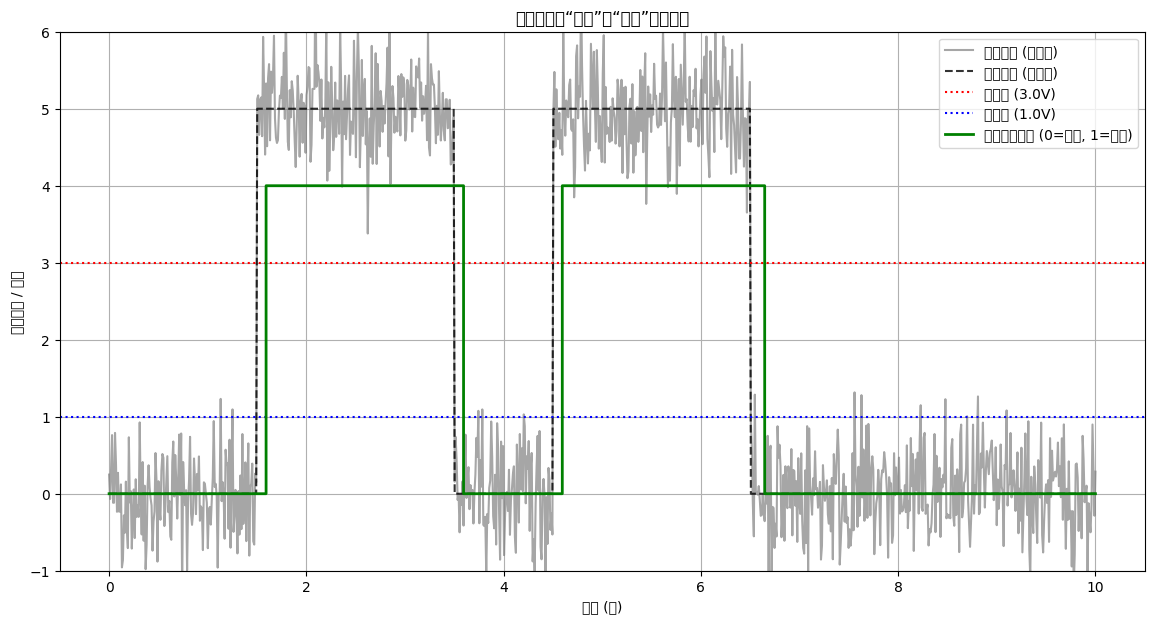


--- 状态转换点 ---
在时间 1.59s 处，状态从 弹起 切换到 按压
在时间 3.59s 处，状态从 按压 切换到 弹起
在时间 4.59s 处，状态从 弹起 切换到 按压
在时间 6.65s 处，状态从 按压 切换到 弹起


In [61]:
import numpy as np
import matplotlib.pyplot as plt

def detect_press_release_state(signal,
                                high_threshold,
                                low_threshold,
                                debounce_samples, # 去抖动所需的连续采样点数
                                initial_state=0): # 初始状态: 0=弹起(低), 1=按压(高)
    """
    将一维信号自动化地分为“按压”和“弹起”两种状态。

    根据电平阈值和去抖动逻辑进行判断。

    参数:
    signal (np.ndarray): 输入的一维信号数组。
    high_threshold (float): 从低电平转为高电平（按压）的阈值。信号必须高于此值。
    low_threshold (float): 从高电平转为低电平（弹起）的阈值。信号必须低于此值。
    debounce_samples (int): 信号在新状态下需要保持的最小连续采样点数，用于去抖动。
                            例如，如果采样率为100Hz，debounce_samples=10，则去抖动延迟为100ms。
    initial_state (int): 初始状态。0表示“弹起”（低电平），1表示“按压”（高电平）。

    返回:
    np.ndarray: 与输入信号等长的状态数组。0表示“弹起”，1表示“按压”。
    """

    if not (isinstance(signal, np.ndarray) and signal.ndim == 1):
        raise ValueError("输入信号必须是一维 NumPy 数组。")
    if high_threshold <= low_threshold:
        raise ValueError("高阈值必须大于低阈值。")
    if debounce_samples < 0:
        raise ValueError("去抖动采样点数不能为负数。")

    states = np.zeros_like(signal, dtype=int)
    current_state = initial_state # 0: 弹起, 1: 按压
    stable_count = 0              # 记录当前状态稳定持续的采样点数

    for i in range(len(signal)):
        current_value = signal[i]

        # 根据当前状态和信号值进行判断
        if current_state == 0: # 当前认为处于“弹起”状态
            if current_value >= high_threshold:
                stable_count += 1
                if stable_count >= debounce_samples:
                    current_state = 1 # 稳定达到高阈值，切换到“按压”状态
                    stable_count = 0  # 重置计数器
            else:
                stable_count = 0 # 未达到高阈值，重置计数器
        
        else: # current_state == 1, 当前认为处于“按压”状态
            if current_value <= low_threshold:
                stable_count += 1
                if stable_count >= debounce_samples:
                    current_state = 0 # 稳定低于低阈值，切换到“弹起”状态
                    stable_count = 0  # 重置计数器
            else:
                stable_count = 0 # 未低于低阈值，重置计数器
        
        states[i] = current_state
    
    return states

# --- 示例使用 ---
if __name__ == "__main__":
    # 模拟一个带噪声的按钮信号
    np.random.seed(42) # 保证结果可复现

    sample_rate = 100 # 采样率，每秒 100 个点
    duration = 10     # 信号持续 10 秒
    num_samples = sample_rate * duration
    time = np.linspace(0, duration, num_samples)

    # 创建一个模拟的按压-弹起序列
    # 初始弹起 (0V)
    # 1.5s - 3.5s 按压 (~5V)
    # 4.5s - 6.5s 按压 (~5V)
    # 其他时间弹起
    true_signal = np.zeros(num_samples)
    true_signal[(time >= 1.5) & (time < 3.5)] = 5
    true_signal[(time >= 4.5) & (time < 6.5)] = 5

    # 添加噪声，模拟真实的传感器输出
    noisy_signal = true_signal + np.random.normal(0, 0.5, num_samples)

    # --- 设置滤波和识别参数 ---
    # 定义高低电平阈值
    # 假设按压电平在 4V 左右，弹起电平在 0V 左右
    high_threshold = 3.0  # 信号高于 3V 才认为是潜在的“按压”
    low_threshold = 1.0   # 信号低于 1V 才认为是潜在的“弹起”

    # 去抖动采样点数
    # 如果采样率为 100Hz，debounce_samples = 10 意味着需要 100ms 的稳定时间
    debounce_delay_ms = 100 # 100 毫秒
    debounce_samples = int(debounce_delay_ms / 1000 * sample_rate)
    print(f"去抖动采样点数: {debounce_samples} (约 {debounce_delay_ms} ms)")


    # --- 执行状态检测 ---
    detected_states = detect_press_release_state(
        signal=noisy_signal,
        high_threshold=high_threshold,
        low_threshold=low_threshold,
        debounce_samples=debounce_samples,
        initial_state=0 # 初始假设为弹起状态
    )

    # --- 可视化结果 ---
    plt.figure(figsize=(14, 7))

    plt.plot(time, noisy_signal, label='原始信号 (带噪声)', alpha=0.7, color='gray')
    plt.plot(time, true_signal, 'k--', label='理想信号 (无噪声)', alpha=0.8, linewidth=1.5)

    # 绘制阈值线
    plt.axhline(y=high_threshold, color='r', linestyle=':', label=f'高阈值 ({high_threshold}V)')
    plt.axhline(y=low_threshold, color='b', linestyle=':', label=f'低阈值 ({low_threshold}V)')

    # 绘制检测到的状态
    plt.plot(time, detected_states * 4, 'g-', drawstyle='steps-post', linewidth=2, label='检测到的状态 (0=弹起, 1=按压)') # 乘以4只是为了在图上显示更清晰

    plt.title('一维信号的“按压”与“弹起”状态检测')
    plt.xlabel('时间 (秒)')
    plt.ylabel('信号电平 / 状态')
    plt.ylim(-1, 6) # 调整Y轴范围以便更好地观察
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- 打印状态转换点 (可选) ---
    print("\n--- 状态转换点 ---")
    current_output_state = detected_states[0]
    for i in range(1, len(detected_states)):
        if detected_states[i] != current_output_state:
            state_text = "按压" if detected_states[i] == 1 else "弹起"
            print(f"在时间 {time[i]:.2f}s 处，状态从 {('弹起', '按压')[current_output_state]} 切换到 {state_text}")
            current_output_state = detected_states[i]